<a href="https://colab.research.google.com/github/mdsatria/aksarabali/blob/master/Transfer%20Learning/TransferLearningResnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 174kB 5.3MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!unzip -qq "gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/train.zip"
!unzip -qq "gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/test.zip"

In [4]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [5]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla P100-PCIE-16GB


## Data Loader

In [6]:
class AksaraBali(Dataset):
    def __init__(self, csv_file, root_dir, height=224, width=224, transform=None):
        self.annotations = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.height = height
        self.width = width
       
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = Image.open(img_path).resize((self.height, self.width))
        y_label = torch.tensor(self.annotations.iloc[index,2], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return(image, y_label)

## Accuracy Check

In [ ]:
# def check_accuracy(loader, model, acc_type):
#     num_correct = 0
#     num_samples = 0
#     model.eval()
    
#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device='cuda:0')
#             y = y.to(device='cuda:0')
            
#             scores = model(x)
#             _, predictions = scores.max(1)
#             num_correct += (predictions == y).sum()
#             num_samples += predictions.size(0)
        
#         print(f'{acc_type} got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
#     model.train()

## Set Training Params

In [7]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
in_channel = 3 
num_classes = 133
learning_rate = 0.001
batch_size = 64
num_epoch = 250

# tranform
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.5005, 0.4670, 0.4174), std=(0.0813, 0.0534, 0.0932))])

train_set = AksaraBali(csv_file="gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/train_label.csv",
                       root_dir="train",
                       transform=my_transform)

test_set = AksaraBali(csv_file="gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/test_label.csv",
                       root_dir="test",
                       transform=my_transform)

#train_set = torch.utils.data(dataset)
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_set,
                          shuffle=False,
                         batch_size=batch_size)
#test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

model = torchvision.models.resnet50(pretrained=True)
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(gpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Training Model

In [34]:
# for epoch in range(num_epoch):
#     losses = []
    
#     for batch_idx, (data, targets) in enumerate(train_loader):
#         # get data to cuda
#         data = data.to(device='cuda:0')
#         targets = targets.to(device='cuda:0')
        
#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)
        
#         losses.append(loss.item())
        
#         # backward
#         optimizer.zero_grad()
#         loss.backward()
        
#         # gradient descent or adam step
#         optimizer.step()
    
#     print(f'Cost at epoch {epoch+1} is {sum(losses)/len(losses)}')
#     check_accuracy(train_loader, model, "Train accuracy ")
#     check_accuracy(test_loader, model, "Test accuracy ")
   
# #torch.save(model, "model1810.pt")

# Train Model pakai Pytorch Ignite

Inisiasi Training dan Evaluation Engine

In [8]:
epochs = 10
trainer = create_supervised_trainer(model, optimizer, criterion, device=gpu)
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=gpu)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=gpu)
training_history = {"accuracy":[], "loss":[]}
validation_history = {"accuracy":[], "loss":[]}
last_epoch = []

### Metrics - `RunningAverage`

In [9]:
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

### `EarlyStopping` Callbacks

In [10]:
def score_function(engine):
  val_loss = engine.state.metrics["loss"]
  return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

### Buat Custom Function
Custom function dibuat untuk menghubungkan dengan dua event yaitu, event saat training dan event saat evaluation.

In [11]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  train_evaluator.run(train_loader)
  metrics = train_evaluator.state.metrics
  accuracy = metrics["accuracy"] * 100
  loss = metrics["loss"]
  last_epoch.append(0)
  training_history["accuracy"].append(accuracy)
  training_history["loss"].append(loss)
  print("Training Results - Epochs: {} Avg. Accuracy: {:.2f} Avg. Loss: {:.2f}"
        .format(trainer.state.epoch, accuracy, loss))
  
def log_validation_results(trainer):
  val_evaluator.run(test_loader)
  metrics = val_evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
        .format(trainer.state.epoch, accuracy, loss))
  
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

### Model Checkpoint

In [12]:
checkpointer = ModelCheckpoint("./saved_models", "aksarabali", n_saved=5, 
                               create_dir=True, save_as_state_dict=True, 
                               require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {"aksarabali": model})

### Run the Engine

In [13]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epochs: 1 Avg. Accuracy: 83.73 Avg. Loss: 0.56
Validation Results - Epoch: 1  Avg accuracy: 73.60 Avg loss: 0.92
Training Results - Epochs: 2 Avg. Accuracy: 92.41 Avg. Loss: 0.26
Validation Results - Epoch: 2  Avg accuracy: 85.47 Avg loss: 0.54
Training Results - Epochs: 3 Avg. Accuracy: 94.33 Avg. Loss: 0.19
Validation Results - Epoch: 3  Avg accuracy: 83.40 Avg loss: 0.60
Training Results - Epochs: 4 Avg. Accuracy: 94.51 Avg. Loss: 0.18
Validation Results - Epoch: 4  Avg accuracy: 86.16 Avg loss: 0.53
Training Results - Epochs: 5 Avg. Accuracy: 95.24 Avg. Loss: 0.16
Validation Results - Epoch: 5  Avg accuracy: 87.48 Avg loss: 0.51
Training Results - Epochs: 6 Avg. Accuracy: 96.16 Avg. Loss: 0.12
Validation Results - Epoch: 6  Avg accuracy: 87.06 Avg loss: 0.50
Training Results - Epochs: 7 Avg. Accuracy: 96.65 Avg. Loss: 0.11
Validation Results - Epoch: 7  Avg accuracy: 85.48 Avg loss: 0.61
Training Results - Epochs: 8 Avg. Accuracy: 97.28 Avg. Loss: 0.09
Validation

State:
	iteration: 4160
	epoch: 10
	epoch_length: 416
	max_epochs: 10
	output: 0.06859813630580902
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plot loss dan accuracy

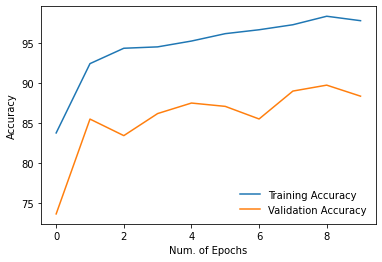

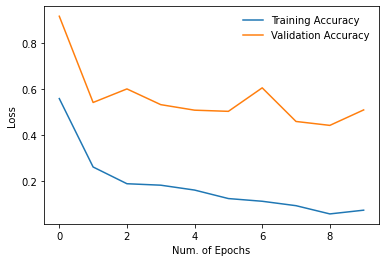

In [15]:
# Accuracy
import matplotlib.pyplot as plt

plt.plot(training_history["accuracy"], label="Training Accuracy")
plt.plot(validation_history["accuracy"], label="Validation Accuracy")
plt.xlabel("Num. of Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

# Loss
plt.plot(training_history["loss"], label="Training Accuracy")
plt.plot(validation_history["loss"], label="Validation Accuracy")
plt.xlabel("Num. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [ ]:
# loading the saved model
# def fetch_last_checkpoint_model_filename(model_save_path):
#     import os
#     checkpoint_files = os.listdir(model_save_path)
#     checkpoint_files = [f for f in checkpoint_files if '.pth' in f]
#     checkpoint_iter = [
#         int(x.split('_')[2].split('.')[0])
#         for x in checkpoint_files]
#     last_idx = np.array(checkpoint_iter).argmax()
#     return os.path.join(model_save_path, checkpoint_files[last_idx])

# model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
# model.load_state_dict(torch.load('./saved_models/aksarabali_aksarabali_11256.pt'))
print("Model Loaded")

### Inferencing the model 